<a href="https://colab.research.google.com/github/hkane206/EnergyPolicy/blob/main/res_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages**

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# **Pre-Processing**

In [ ]:
# From before: read in csv and classify renewable vs nonrenewable energy sources
energy_production = pd.read_csv("/content/organised_Gen.csv")
energy_production.drop(['Unnamed: 0', 'TYPE OF PRODUCER'], axis=1, inplace=True)

renewable_energy_sources = ["Hydroelectric Conventional", "Wind", "Wood and Wood Derived Fuels", "Other Biomass", "Solar Thermal and Photovoltaic", "Geothermal"]
nonrenewable_energy_sources = ["Coal", "Petroleum", "Natural Gas", "Nuclear"]

energy_production["RENEWABLE"] = np.where(energy_production["ENERGY SOURCE"].isin(renewable_energy_sources), "Renewable",
                                 np.where(energy_production["ENERGY SOURCE"].isin(nonrenewable_energy_sources), "Nonrenewable", "Other"))

In [ ]:
# For time series analysis, create DATE column

energy_production['DATE'] = pd.to_datetime(energy_production['YEAR'].astype(str) + '-' + energy_production['MONTH'].astype(str).str.zfill(2) + '-01')
energy_production = energy_production.sort_values('DATE')

grouped_ep = energy_production.groupby(['STATE', 'DATE', 'RENEWABLE'])['GENERATION (Megawatthours)'].sum().unstack()
grouped_ep['RES'] = 100 * grouped_ep['Renewable']/(grouped_ep['Nonrenewable']+grouped_ep['Renewable']).replace(0,1)

grouped_ep.head()

RENEWABLE         Nonrenewable      Other  Renewable        RES
STATE DATE                                                     
AK    2001-01-01      971018.0  1180290.0   209272.0  17.730558
      2001-02-01      911964.0  1092334.0   180370.0  16.512349
      2001-03-01      974382.0  1174230.0   199848.0  17.019494
      2001-04-01      808024.0   977396.0   169372.0  17.328903
      2001-05-01      798976.0   969374.0   170398.0  17.578148

# **Visualize Time Series Plots**

<Figure size 1200x600 with 0 Axes>

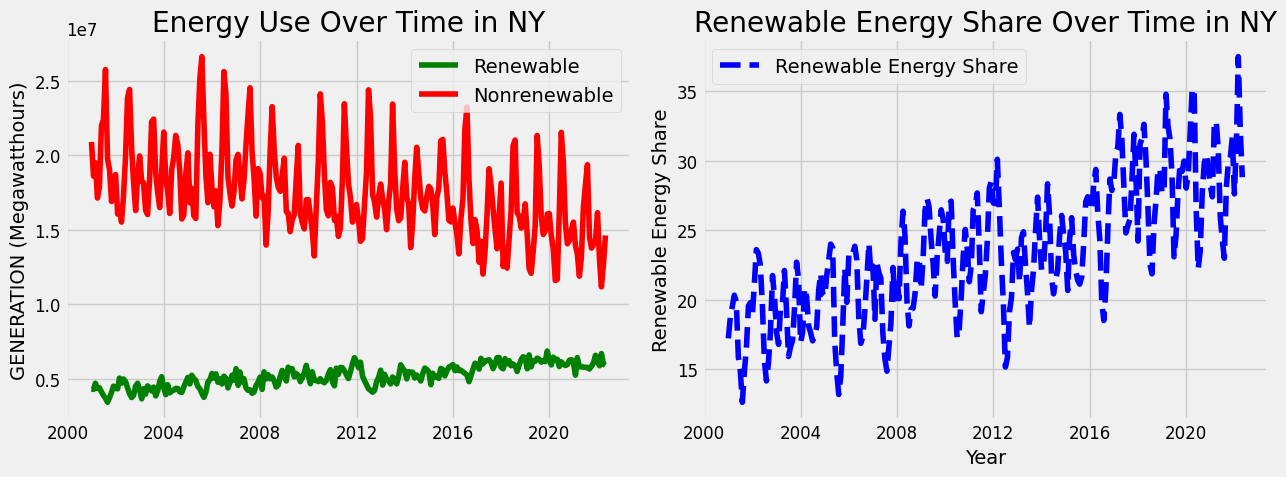

In [ ]:
state = "NY"
# Filter data for state
state_data = grouped_ep.xs(key=state, level='STATE')

# Plot
plt.figure(figsize=(12, 6))

# Create a 2-row figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5), sharex=True)


# Plot renewable and nonrenewable on the top plot
if 'Renewable' in state_data.columns:
    ax1.plot(state_data.index, state_data['Renewable'], label='Renewable', color='green')

if 'Nonrenewable' in state_data.columns:
    ax1.plot(state_data.index, state_data['Nonrenewable'], label='Nonrenewable', color='red')

ax1.set_title('Energy Use Over Time in ' + state)
ax1.set_ylabel('GENERATION (Megawatthours)')
ax1.grid(True)
ax1.legend()


# Plot the ratio on the bottom plot
ax2.plot(state_data.index, state_data['RES'], label='Renewable Energy Share', color='blue', linestyle='--')
ax2.set_title('Renewable Energy Share Over Time in ' + state)
ax2.set_xlabel('Year')
ax2.set_ylabel('Renewable Energy Share')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Filter out data after 2019 because of COVID
#state_data = state_data[state_data.index.year <= 2019]

# **Time-Series Decomposition**

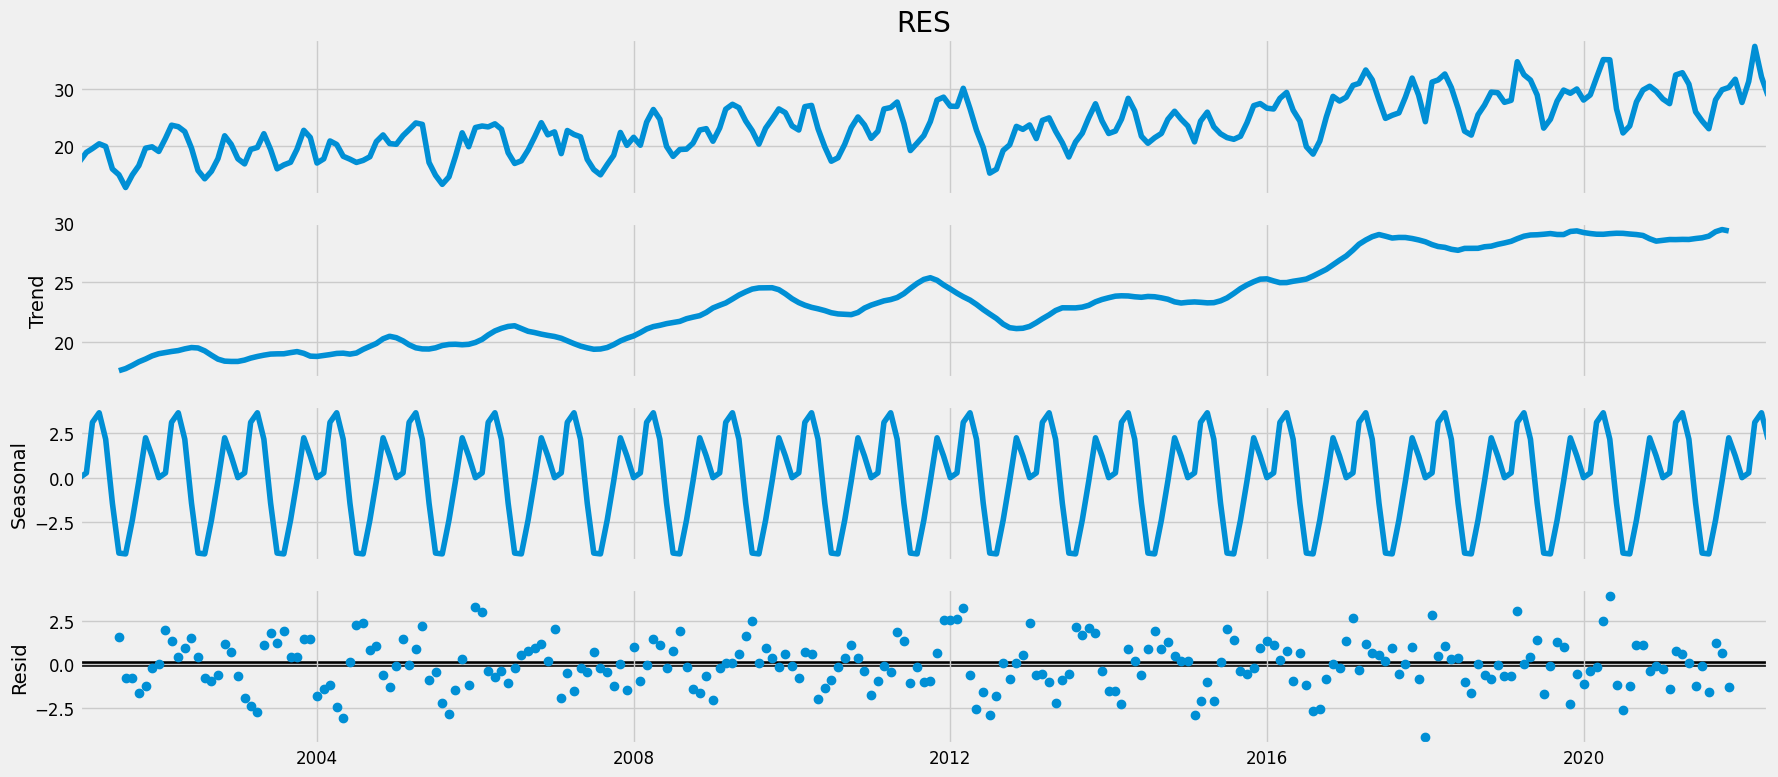

In [ ]:
y = state_data['RES'].resample('MS').sum()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# **Optimize ARIMA**

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:

  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2354.647163120764
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1989.10856739186
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1181.1373878561046
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1084.7663085537388
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1181.3913870137176
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1057.2335212939356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1089.1407354205799
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1085.1837536088797
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2031.429917302757
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1711.6061520932562
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1071.8920192634266
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:971.8052570706703
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1079.6969569011208


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1079.5884339833253
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:986.2667545006516
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:972.7693636107354
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1210.8568501705727
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1085.4360294314704
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1057.8010909311547
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:921.0451915736923
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1026.5609820073614
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:970.6173461683676
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:975.3842025716679
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:927.4468249045916
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1189.957344890754
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1080.9889202034306
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1041.6257379427125
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:899.4732366725987
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1021.650988142118
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:947.6949108006909
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:963.4820737376324
ARI

# **Fit ARIMA**

Lowest AIC value at
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:883.3560240714289


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6128      0.057     10.766      0.000       0.501       0.724
ma.L1         -0.9636      0.023    -41.490      0.000      -1.009      -0.918
ma.S.L12      -1.1412      0.082    -13.950      0.000      -1.302      -0.981
sigma2         1.9147      0.282      6.788      0.000       1.362       2.468


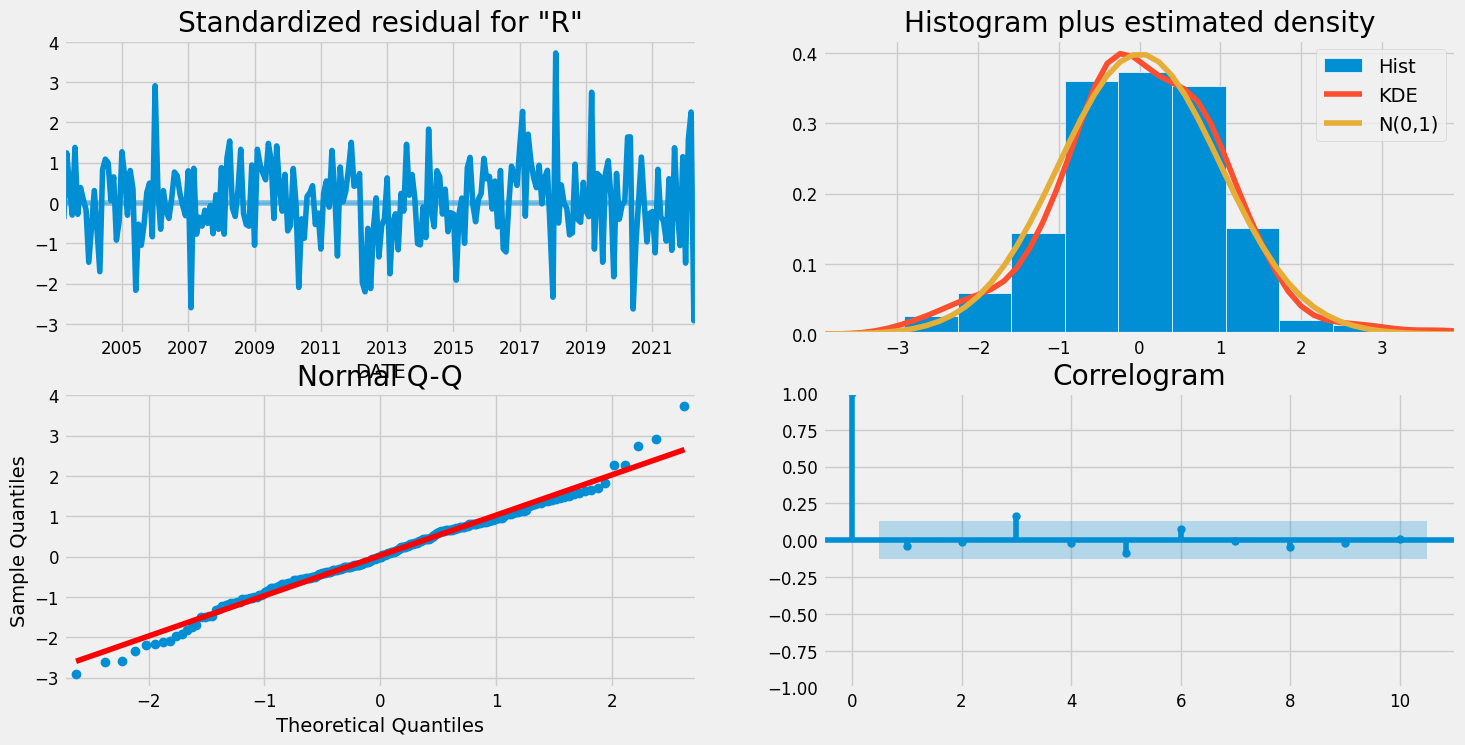

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

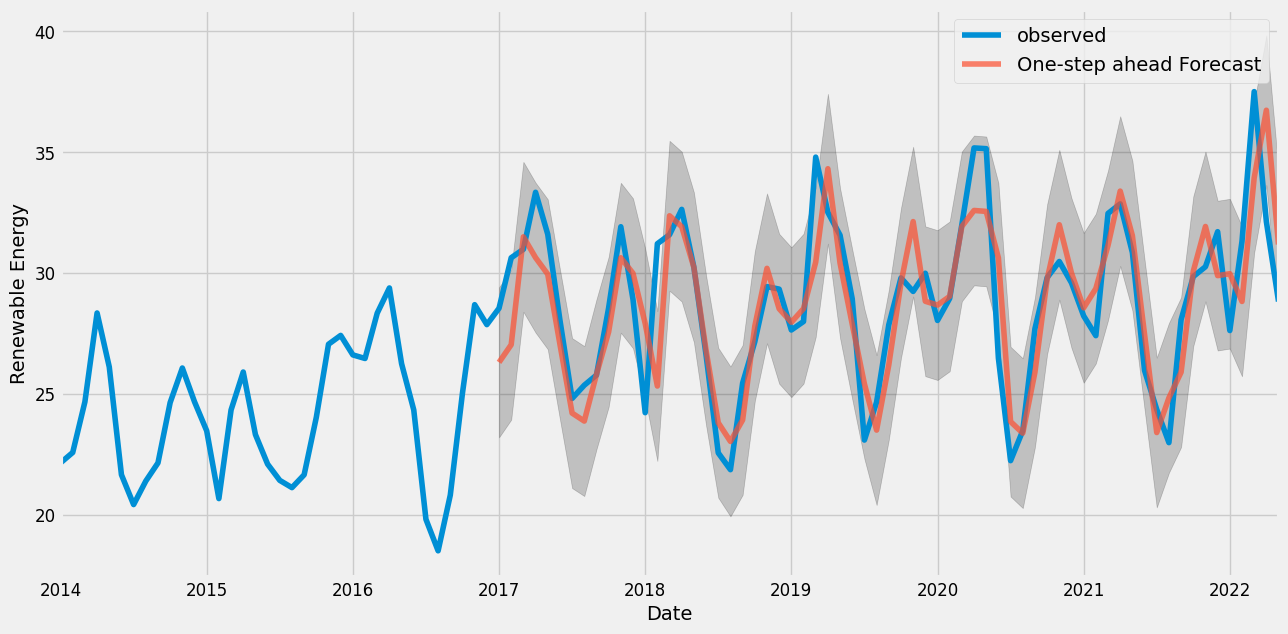

In [ ]:
#Validate forecasts

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 3.86
The Root Mean Squared Error of our forecasts is 1.96


# **Forecasting**

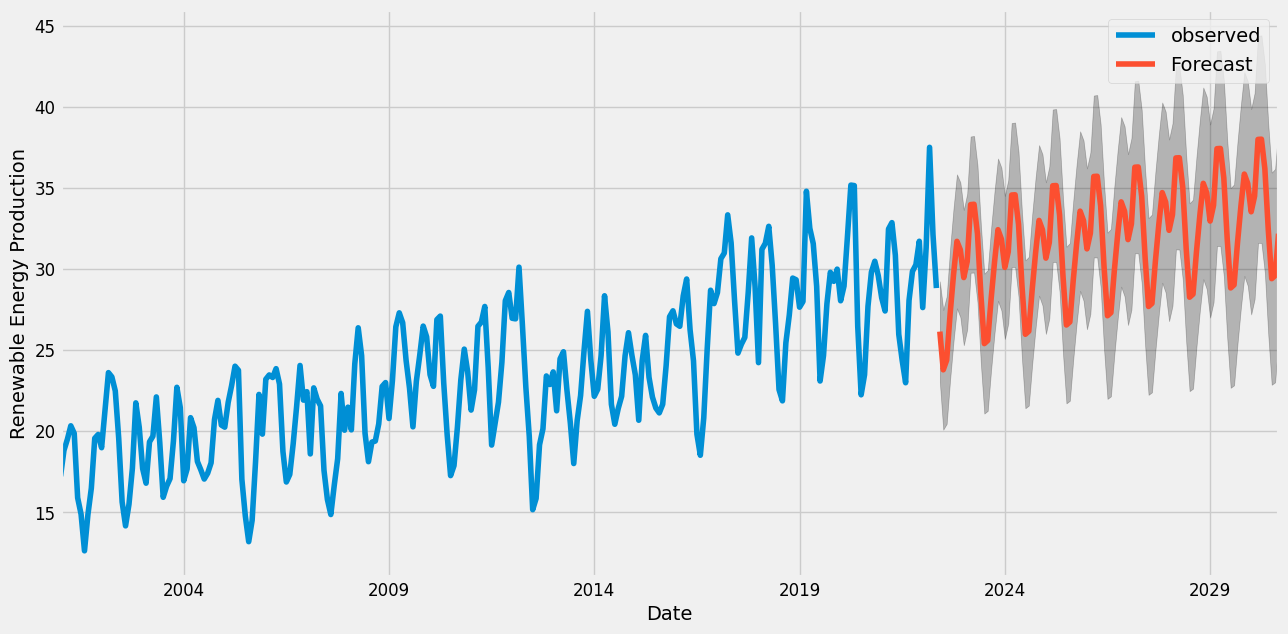

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy Production')

plt.legend()
plt.show()